Step 1: Load torch and Cuda.

In [ ]:
!pip3 install kornia
#CUDA 13.0 build of Torch
#--upgrade ensures that previous versions that are cached are not used
!pip3 install --upgrade torch torchvision --index-url https://download.pytorch.org/whl/cu130
!pip3 install tqdm matplotlib requests
!pip3 install nltk

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 19.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip3 show torch torchvision
#ensure that the torch version is dictated by a "cu+" number for CUDA linking

Name: torch
Version: 2.9.1+cu130
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org
Author: 
Author-email: PyTorch Team <packages@pytorch.org>
License: BSD-3-Clause
Location: C:\Program Files\Python313\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, setuptools, sympy, typing-extensions
Required-by: kornia, torchvision
---
Name: torchvision
Version: 0.24.1+cu130
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: C:\Program Files\Python313\Lib\site-packages
Requires: numpy, pillow, torch
Required-by: 


In [4]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import random
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
import zipfile
import requests
import os
from PIL import Image 
import numpy as np
import time
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\save_\AppData\Roaming\nltk_data...


In [5]:
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: True
Device: NVIDIA GeForce RTX 4070 Laptop GPU


Step 2: Load resnet 18    

In [7]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-18
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode
model = model.to(device)  # Move model to GPU

c:\Program Files\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\save_/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:03<00:00, 33.1MB/s]


Step 3 (Optional) Test resnet 18 on imagenet mini validation.

In [9]:
#Substep 1: Define a transform to change dataset to expected input for resnet18

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transformTest = transforms.Compose([
    transforms.ToTensor()
])
transformToTensor = transforms.Compose([
    transforms.ToTensor()
])

In [10]:

if(os.path.isdir("imagenet-mini")):
        print("The dataset folder is already present.")
else:
    imageNetMiniUrl = "https://www.kaggle.com/api/v1/datasets/download/ifigotin/imagenetmini-1000"
    output_filename = "imagenet-mini.zip"
    try:
        with requests.get(imageNetMiniUrl,stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('Content-Length',0))
            if os.path.exists(output_filename) and os.path.getsize(output_filename) >= total_size:
                print(f"The file is already found with a file size of {os.path.getsize(output_filename)}")
                r.close()
            else:
                with open(output_filename,"wb") as f,tqdm(total=total_size,unit='B',unit_scale=True) as progress_bar:
                    for chunk in r.iter_content():
                        r.raise_for_status()
                        if(chunk):
                            f.write(chunk)
                            progress_bar.update(len(chunk))
    except requests.exceptions.HTTPError as e:
        print(f'Error during download process: {e}')
    except requests.exceptions.RequestException as e:
            print(f"Error during query request: {e}")
    except IOError as e:
            print(f"Error writing file: {e}")

    with zipfile.ZipFile(output_filename) as z:
        z.printdir()
        z.extractall('.')



The dataset folder is already present.


In [11]:
val_dataset = ImageFolder(root='imagenet-mini/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
val_classes = val_dataset.classes

val_dataset_clean = ImageFolder(root='imagenet-mini/val', transform=transformToTensor)
val_loader_clean = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_dataset = ImageFolder(root='imagenet-mini/train', transform=transformTest)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


In [12]:
#Substep 3: Calculate the accuracy
top1_correct = 0
top5_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # Top-1 accuracy
        _, top1_pred = outputs.topk(1, dim=1)
        top1_correct += (top1_pred.squeeze() == labels).sum().item()

        # Top-5 accuracy
        _, top5_pred = outputs.topk(5, dim=1)
        for i in range(labels.size(0)):
            if labels[i] in top5_pred[i]:
                top5_correct += 1

        total += labels.size(0)

print(f"Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"Top-5 Accuracy: {top5_correct / total:.4f}")

100%|██████████| 123/123 [01:11<00:00,  1.71it/s]

Top-1 Accuracy: 0.7573
Top-5 Accuracy: 0.9307


Step 4: Adversarial patch Generation


In [ ]:
#Substep 1: Be able to simulate perspective rotations
#We will be using Kornia, which allows you to rotate and do perspecive on tensors

In [13]:
import kornia
import kornia.augmentation as K
print("Kornia version:", kornia.__version__)

Kornia version: 0.8.2


In [14]:
#Random learnable patch
patch_size = 100
patch = torch.rand(1, 3, patch_size, patch_size, requires_grad=True, device='cuda')

In [15]:
def embed_patch_and_mask(patch):
    C, H, W = patch.shape
    canvas_size = 500

    canvas = torch.zeros((1, C, canvas_size, canvas_size), device=patch.device)
    mask = torch.zeros((1, 1, canvas_size, canvas_size), device=patch.device)

    y_offset = (canvas_size - H) // 2
    x_offset = (canvas_size - W) // 2

    canvas[0, :, y_offset:y_offset+H, x_offset:x_offset+W] = patch
    mask[0, :, y_offset:y_offset+H, x_offset:x_offset+W] = 1.0

    return canvas, mask

In [16]:
visualize = False
def transform_patch_and_mask(patch, mask, angle_deg, scale, tilt_amount):
    B, C, H, W = patch.shape
    cx = W / 2
    cy = H / 2

    angle_rad = torch.tensor(angle_deg * torch.pi / 180, device=patch.device)
    cos_a = torch.cos(angle_rad)
    sin_a = torch.sin(angle_rad)

    # Convert to 3×3 homogeneous matrices
    T1 = torch.eye(3, device=patch.device)
    T1[0, 2] = -cx
    T1[1, 2] = -cy

    R = torch.eye(3, device=patch.device)
    R[0, 0] = scale * cos_a
    R[0, 1] = -scale * sin_a
    R[1, 0] = scale * sin_a
    R[1, 1] = scale * cos_a

    T2 = torch.eye(3, device=patch.device)
    T2[0, 2] = cx
    T2[1, 2] = cy

    # Composite transform: T2 @ R @ T1
    A_hom = T2 @ R @ T1  # shape: [3, 3]
    A_affine = A_hom[:2, :]  # convert back to 2×3
    affine_matrix = A_affine.unsqueeze(0)  # shape: [1, 2, 3]

    # Apply affine transform
    patch = kornia.geometry.transform.warp_affine(patch, affine_matrix, dsize=(W, H), align_corners=False)
    mask = kornia.geometry.transform.warp_affine(mask, affine_matrix, dsize=(W, H), align_corners=False)

    # Perspective warp
    src_pts = torch.tensor([[[-1, -1], [1, -1], [1, 1], [-1, 1]]], dtype=torch.float32).to(patch.device)
    dst_pts = src_pts + (torch.rand_like(src_pts) - 0.5) * 2 * tilt_amount/10000

    M = kornia.geometry.transform.get_perspective_transform(src_pts, dst_pts)
    patch = kornia.geometry.transform.warp_perspective(patch, M, dsize=(W, H))
    mask = kornia.geometry.transform.warp_perspective(mask, M, dsize=(W, H))
    if visualize:
        # Visualization
        patch_vis = patch[0].detach().cpu().clamp(0, 1)
        if patch_vis.shape[0] == 1:
            patch_vis = patch_vis.squeeze(0).numpy()
            plt.imshow(patch_vis, cmap="gray")
        else:
            patch_vis = patch_vis.permute(1, 2, 0).numpy()
            plt.imshow(patch_vis)
        plt.title(f"Transformed Patch\nAngle: {angle_deg:.1f}°, Scale: {scale:.2f}, Tilt: {tilt_amount:.2f}")
        plt.axis("off")
        plt.show()

    return patch, mask

In [17]:
def random_overlay_patch(image, patch, max_tilt=10):
    B, C, H, W = image.shape
    device = image.device
    angle_deg = random.uniform(0, 360)
    tilt_amount = random.uniform(0, max_tilt)
    
    # Image constraints
    min_dim = min(H, W)
    min_allowed = min_dim / 6   # smallest acceptable patch size
    max_allowed = min_dim / 4   # largest acceptable patch size

    # Original patch dimensions
    ph, pw = patch.shape[2:]
    patch_min_side = min(ph, pw)

    # Compute scale bounds so patch fits between min_allowed and max_allowed
    min_scale = min_allowed / patch_min_side
    max_scale = max_allowed / patch_min_side

    # Sample scale uniformly in that range
    scale = random.uniform(min_scale, max_scale)


    # Embed and transform
    embedded_patch, embedded_mask = embed_patch_and_mask(patch.squeeze(0))
    
     # Apply lighting simulation before transformation
    lighting_aug = K.ColorJitter(brightness=0.15, contrast=0.2, saturation=0.1, hue=0.1, p=1.0)
    embedded_patch = lighting_aug(embedded_patch)

    transformed_patch, transformed_mask = transform_patch_and_mask(embedded_patch, embedded_mask, angle_deg, scale, tilt_amount)

    # Crop valid region
    mask = transformed_mask.squeeze(0).squeeze(0) > 0.5
    rows = torch.any(mask, dim=1)
    cols = torch.any(mask, dim=0)
    if not rows.any() or not cols.any():
        return image

    y_min, y_max = rows.nonzero()[0].item(), rows.nonzero()[-1].item()
    x_min, x_max = cols.nonzero()[0].item(), cols.nonzero()[-1].item()

    patch_crop = transformed_patch[:, :, y_min:y_max+1, x_min:x_max+1]
    mask_crop = transformed_mask[:, :, y_min:y_max+1, x_min:x_max+1]

    ph, pw = patch_crop.shape[2:]
    x = random.randint(0, W - pw)
    y = random.randint(0, H - ph)

    # Blend using mask
    patched_image = image.clone()
    patch_crop = patch_crop.squeeze(0)
    mask_crop = mask_crop.squeeze(0)

    patched_region = patched_image[0, :, y:y+ph, x:x+pw]
    patched_image[0, :, y:y+ph, x:x+pw] = patch_crop * mask_crop + patched_region * (1 - mask_crop)

    return patched_image

Image tensor data type:  torch.float32


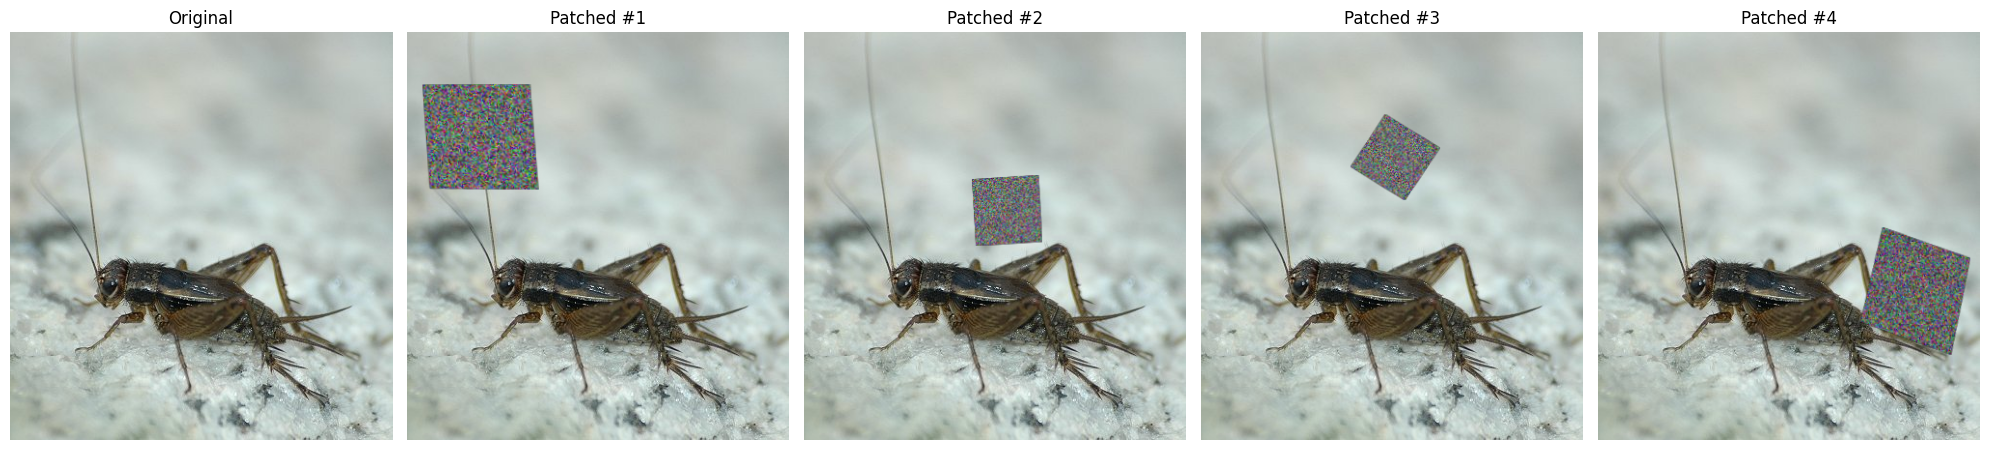

In [18]:
# Get a random image from the training set
image_tensor, label = random.choice(train_dataset)
print("Image tensor data type: ", image_tensor.dtype)
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

# Convert to CPU for visualization
def to_pil(tensor):
    return TF.to_pil_image(tensor.squeeze().cpu().clamp(0, 1))

# Generate 4 patched versions
patched_images = []
for _ in range(4):
    patched = random_overlay_patch(image_tensor, patch)
    patched_images.append(to_pil(patched))

# Plot original + patched images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(to_pil(image_tensor.squeeze(0)))
axes[0].set_title("Original")
for i in range(4):
    axes[i+1].imshow(patched_images[i])
    axes[i+1].set_title(f"Patched #{i+1}")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - loss: -8749.4732


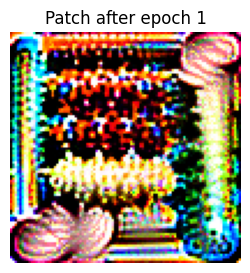

 20%|██        | 1/5 [15:21<1:01:27, 921.83s/it]

Epoch 2/5 - loss: -8833.8167


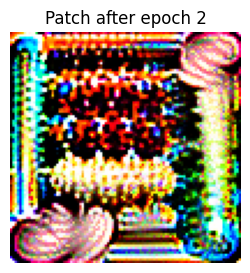

 40%|████      | 2/5 [30:47<46:12, 924.14s/it]  

Epoch 3/5 - loss: -8966.8966


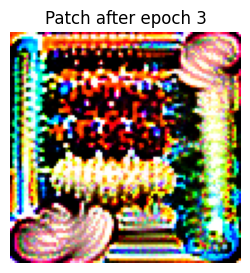

 60%|██████    | 3/5 [46:21<30:57, 928.82s/it]

Epoch 4/5 - loss: -9007.7943


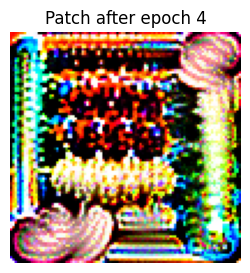

 80%|████████  | 4/5 [1:01:58<15:31, 931.94s/it]

Epoch 5/5 - loss: -9042.3698


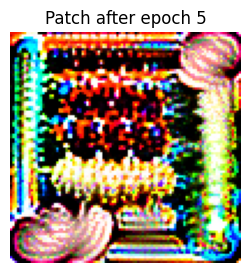

100%|██████████| 5/5 [1:17:17<00:00, 927.44s/it]


In [21]:
import time
import torch.nn.functional as F
runningVis = True
targeted = False
target_class = None
num_epochs = 5

def total_variation(x):
    # x: [B, C, H, W]
    tv_h = torch.mean(torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]))
    tv_w = torch.mean(torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]))
    return tv_h + tv_w

def patch_regularization(patch, tv_weight=0.001, l2_weight=0.0005):
    # Encourage smoothness and keep values bounded
    tv_loss = tv_weight * total_variation(patch)
    l2_loss = l2_weight * (patch**2).mean()
    return tv_loss + l2_loss

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
optimizer = torch.optim.Adam([patch], lr=0.01)
def train_adversarial_patch(model, dataset, batch_size=32, num_epochs=5):
    global patch
    model.eval()
    last_vis_time = time.time()

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        patched_batch = []
        label_batch = []

        for i, (img, label) in enumerate(dataset):
            #print("On image ", i)
            img = img.unsqueeze(0).to(device)   # [1, C, H, W]
            label = torch.tensor([label], device=device)

            # Overlay patch first
            patched_img = random_overlay_patch(img, patch)

            # Preprocess AFTER patching
            patched_img = preprocess(patched_img.squeeze(0)).unsqueeze(0)

            patched_batch.append(patched_img)
            label_batch.append(label)

            # When we’ve collected a batch, run it
            if len(patched_batch) == batch_size:
                batch_tensor = torch.cat(patched_batch, dim=0).to(device)
                batch_labels = torch.cat(label_batch, dim=0).to(device)

                logits = model(batch_tensor)

                if targeted:
                    target_labels = torch.full_like(batch_labels, fill_value=target_class)
                    loss_main = F.cross_entropy(logits, target_labels)
                else:
                    loss_main = -F.cross_entropy(logits, batch_labels)

                loss_reg = patch_regularization(patch)
                loss = loss_main + loss_reg

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                patch.data.clamp_(0, 1)

                running_loss += loss.item()

                # Reset batch buffers
                patched_batch, label_batch = [], []

                # --- Visualization every 10 seconds ---
                if time.time() - last_vis_time > 10 and runningVis:
                    #print("Patch so far:")
                    with torch.no_grad():
                        
                        plt.figure(figsize=(3, 3))
                        plt.imshow(patch[0].detach().cpu().permute(1, 2, 0).clamp(0, 1).numpy())
                        plt.title(f"Patch update (epoch {epoch+1}, step {i})")
                        plt.axis("off")
                        #plt.show()
                        plt.savefig(f"./images/patch_epoch{epoch+1}_step{i}.png")
                        plt.close()
                    last_vis_time = time.time()

        print(f"Epoch {epoch+1}/{num_epochs} - loss: {running_loss:.4f}")

        # Visualize patch
        with torch.no_grad():
            plt.figure(figsize=(3, 3))
            plt.imshow(patch[0].detach().cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            plt.title(f"Patch after epoch {epoch+1}")
            plt.axis("off")
            plt.savefig(f"./images/patch_after_epoch{epoch+1}.png")
            plt.show()
            plt.close()

    return patch
os.mkdir("./images")
final_patch = train_adversarial_patch(model, train_dataset)

Image tensor data type:  torch.float32


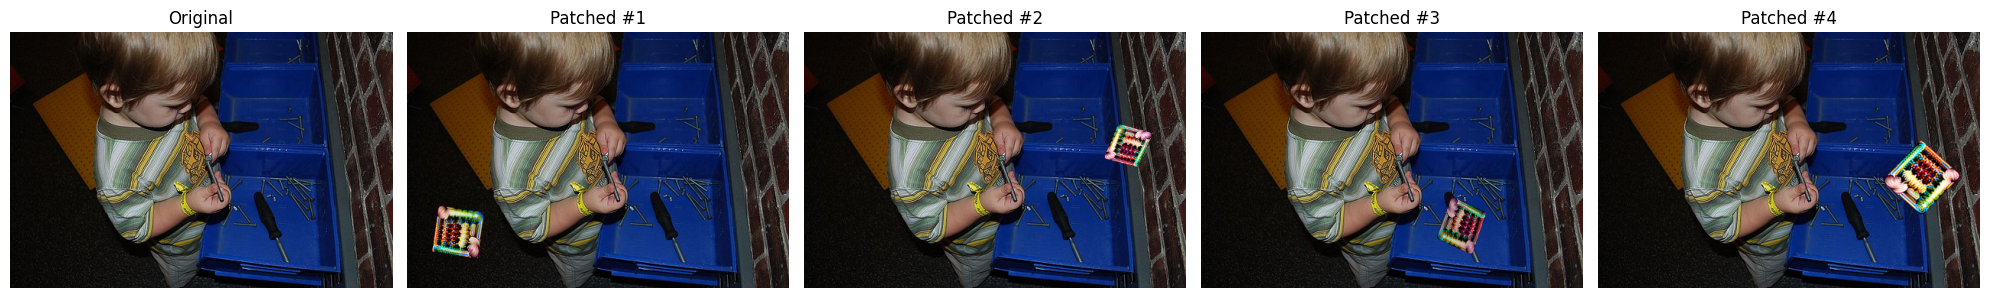

In [25]:
# Get a random image from the training set
image_tensor, label = random.choice(train_dataset)
print("Image tensor data type: ", image_tensor.dtype)

image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

def pil_to_tensor(pil_image_path):
    pil = Image.open(pil_image_path)
    pil_np = np.array(pil)
    pil_tensor = transforms.ToTensor()(pil).unsqueeze(0).to(device)
    return pil_tensor

# Convert to CPU for visualization
def to_pil(tensor):
    return TF.to_pil_image(tensor.squeeze().cpu().clamp(0, 1))

# Generate 4 patched versions
patched_images = []
if not final_patch is None:
    patch = final_patch
else:
    patch = pil_to_tensor("dgxepoch5.tga")
for _ in range(4):
    patched = random_overlay_patch(image_tensor, patch)
    patched_images.append(to_pil(patched))

# Plot original + patched images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(to_pil(image_tensor.squeeze(0)))
axes[0].set_title("Original")
for i in range(4):
    axes[i+1].imshow(patched_images[i])
    axes[i+1].set_title(f"Patched #{i+1}")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [28]:
top1_correct_before = 0
top5_correct_before = 0
top1_correct_after = 0
top5_correct_after = 0
total = 0
verbose = False
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

if not final_patch is None:
    patch = final_patch
else:
    patch = pil_to_tensor("dgxepoch5.tga")
model.eval()
with torch.no_grad():
    for i, (image, label)  in tqdm(enumerate(val_dataset_clean)):
        #print("On image", i)
        #Raw, raw with patch, Preprocessed, preprocessed with patch
        #Raw and ground truth
        image_tensor = image.unsqueeze(0).to(device) # [1, C, H, W] 
        label_tensor = torch.tensor([label], device=device)
        gt_id = label_tensor.item()
        gt_class = val_classes[gt_id]
        gt_str = wn.synset_from_pos_and_offset(gt_class[:1], int(gt_class[1:])).lemma_names()[0]
        
        #Raw with patch applied
        patched_tensor = random_overlay_patch(image_tensor, patch) 

        #Raw preprocessed 
        preprocessed_image = preprocess(image_tensor.squeeze(0)).unsqueeze(0).to(device)
        
        #Preprocessing improves model accuracy significantly
        outputs_before = model(preprocessed_image)
        
        # Top-1 accuracy Before Patch
        _, top1_pred_before = outputs_before.topk(1, dim=1)
        top1_pred_id_before = top1_pred_before.squeeze().item()
        top1_pred_class_before = val_classes[top1_pred_id_before]
        top1_pred_str_before = wn.synset_from_pos_and_offset(top1_pred_class_before[:1], int(top1_pred_class_before[1:])).lemma_names()[0]

        if(top1_pred_before.squeeze() == label_tensor):
            top1_correct_before += 1

        # Top-5 accuracy before patch
        _, top5_pred_before = outputs_before.topk(5, dim=1)
        top5_pred_str_before = []
        for i in range(top5_pred_before[0].size(0)): #iterating 5 times
            pred_id = top5_pred_before[0][i].item()
            pred_class = val_classes[pred_id]
            pred_str = wn.synset_from_pos_and_offset(pred_class[:1], int(pred_class[1:])).lemma_names()[0]
            #print(pred_str)
            top5_pred_str_before.append(pred_str)
            if label_tensor[0] in top5_pred_before[0][i]:
                top5_correct_before += 1

        #Preprocessed with patch
        preprocessed_image_patch = preprocess(patched_tensor.squeeze(0)).unsqueeze(0).to(device)
        outputs_after = model(preprocessed_image_patch) #should produce incorrect results

        # Top-1 accuracy after Patch
        _, top1_pred_after = outputs_after.topk(1, dim=1)
        top1_pred_id_after = top1_pred_after.squeeze().item()
        top1_pred_class_after = val_classes[top1_pred_id_after]
        top1_pred_str_after = wn.synset_from_pos_and_offset(top1_pred_class_after[:1], int(top1_pred_class_after[1:])).lemma_names()[0]
        if(top1_pred_after.squeeze() == label_tensor):
            top1_correct_after += 1

        # Top-5 accuracy after patch
        _, top5_pred_after = outputs_after.topk(5, dim=1)
        top5_pred_str_after = []
        for i in range(top5_pred_after[0].size(0)): #iterating 5 times
            pred_id = top5_pred_after[0][i].item()
            pred_class = val_classes[pred_id]
            pred_str = wn.synset_from_pos_and_offset(pred_class[:1], int(pred_class[1:])).lemma_names()[0]
            #print(pred_str)
            top5_pred_str_after.append(pred_str)
            if label_tensor[0] in top5_pred_after[0][i]:
                top5_correct_after += 1


        total += 1
        if verbose:
            print(f"Ground Truth: {gt_str}")
            print(f"Top-1 Prediction Before Patch: {top1_pred_str_before}")
            print(f"Top-5 Predictions Before Patch: {top5_pred_str_before}")
            print(f"Top-1 Prediction After Patch: {top1_pred_str_after}")
            print(f"Top-5 Predictions After Patch: {top5_pred_str_after}")
            figure, ax=plt.subplots(1,4,figsize=(12,6))
            ax[0].imshow(image_tensor.squeeze(0).cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            ax[1].imshow(patched_tensor.squeeze(0).cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            ax[2].imshow(preprocessed_image.squeeze(0).cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            ax[3].imshow(preprocessed_image_patch.squeeze(0).cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            plt.show()

        
top1_acc_before = top1_correct_before / total
top5_acc_before = top5_correct_before / total
top1_acc_after = top1_correct_after / total
top5_acc_after = top5_correct_after / total
print(f"Top-1 Accuracy Before : {top1_acc_before:.4f}, Top-5 Accuracy Before: {top5_acc_before:.4f}")
print(f"Top-1 Accuracy After : {top1_acc_after:.4f}, Top-5 Accuracy After: {top5_acc_after:.4f}")

3923it [02:12, 29.50it/s]

Top-1 Accuracy Before : 0.7568, Top-5 Accuracy Before: 0.9312
Top-1 Accuracy After : 0.2335, Top-5 Accuracy After: 0.6972
